In [8]:
import os
import random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import itertools

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.metrics import confusion_matrix, classification_report

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.20.0


In [9]:
DATA_DIR = Path("data")
TRAIN_DIR = DATA_DIR / "train"
VAL_DIR = DATA_DIR / "valid"
TEST_DIR = DATA_DIR / "test"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42
NUM_CLASSES_LIMIT = 10   
AUTOTUNE = tf.data.AUTOTUNE


In [50]:
def get_classes(directory, limit=None):
    classes = sorted([d.name for d in Path(directory).iterdir() if d.is_dir()])
    if limit:
        classes = classes[:limit]
    return classes

classes = get_classes(TRAIN_DIR, NUM_CLASSES_LIMIT)
print("Using Classes:")
for c in classes:
    print(" -", c)


Using Classes:
 - Apple___Apple_scab
 - Apple___Black_rot
 - Apple___Cedar_apple_rust
 - Apple___healthy
 - Blueberry___healthy
 - Cherry_(including_sour)___Powdery_mildew
 - Cherry_(including_sour)___healthy
 - Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
 - Corn_(maize)___Common_rust_
 - Corn_(maize)___Northern_Leaf_Blight


In [51]:
def load_dataset(directory, class_names, shuffle=True):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        labels="inferred",
        label_mode="int",
        class_names=class_names, # This ensures only the 10 classes are loaded
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        seed=SEED,
        shuffle=shuffle
    )
    print("Class Names:", ds.class_names)
    
    # REMOVED THE DIVISION BY 255.0 HERE
    # Just cast to float32, keep range [0, 255]
    ds = ds.map(lambda x, y: (tf.cast(x, tf.float32), y),
                num_parallel_calls=AUTOTUNE)

    return ds.prefetch(AUTOTUNE)

# Reload datasets
train_ds = load_dataset(TRAIN_DIR, classes, shuffle=True)
val_ds   = load_dataset(VAL_DIR, classes, shuffle=False)

Found 18553 files belonging to 10 classes.
Class Names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight']
Found 4638 files belonging to 10 classes.
Class Names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight']


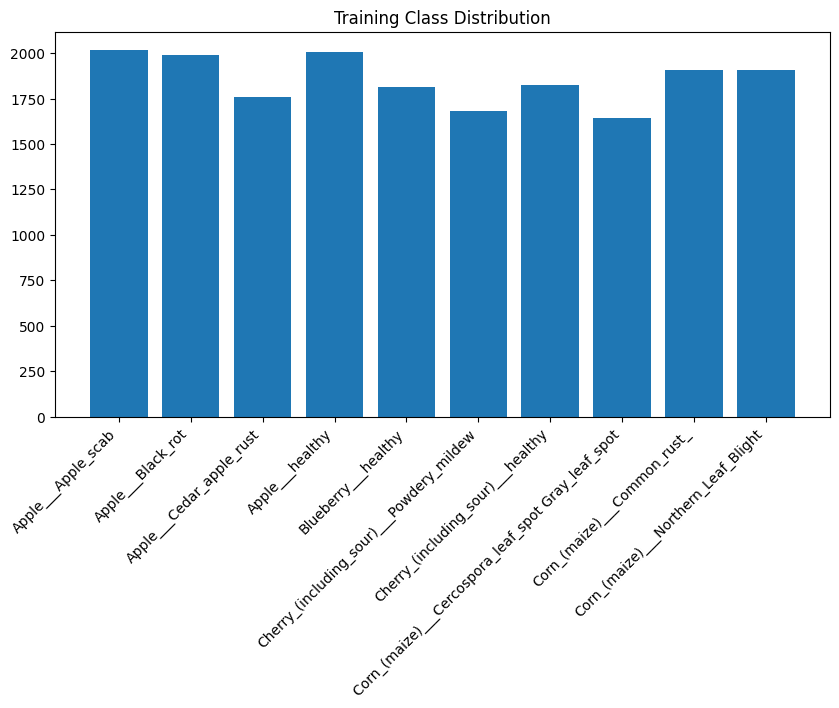

In [54]:
counts = {c: len(list((TRAIN_DIR / c).glob("*"))) for c in classes}

plt.figure(figsize=(10,5))
plt.bar(range(len(classes)), list(counts.values()))
plt.xticks(range(len(classes)), classes, rotation=45, ha='right')
plt.title("Training Class Distribution")
plt.show()


In [17]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.15),
], name="augmentation")


In [19]:
base_model = tf.keras.applications.EfficientNetV2B0(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False


24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


In [55]:
inputs = layers.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)

# EfficientNet expects [0, 255] inputs. 
# This layer handles specific requirements for V2.
x = tf.keras.applications.efficientnet_v2.preprocess_input(x)

x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(len(classes), activation="softmax")(x)

model = models.Model(inputs, outputs)
model.compile(
    optimizer=optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

Epoch 1/12
580/580 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.1083 - loss: 2.3271

580/580 ━━━━━━━━━━━━━━━━━━━━ 315s 527ms/step - accuracy: 0.1079 - loss: 2.3095 - val_accuracy: 0.1087 - val_loss: 2.3006 - learning_rate: 0.0010
Epoch 2/12
580/580 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.0987 - loss: 2.3010

580/580 ━━━━━━━━━━━━━━━━━━━━ 284s 490ms/step - accuracy: 0.1040 - loss: 2.3007 - val_accuracy: 0.1087 - val_loss: 2.3003 - learning_rate: 0.0010
Epoch 3/12
580/580 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.1063 - loss: 2.3007

580/580 ━━━━━━━━━━━━━━━━━━━━ 281s 484ms/step - accuracy: 0.1075 - loss: 2.3005 - val_accuracy: 0.1087 - val_loss: 2.3003 - learning_rate: 0.0010
Epoch 4/12
580/580 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.1061 - loss: 2.3008

580/580 ━━━━━━━━━━━━━━━━━━━━ 283s 487ms/step - accuracy: 0.1078 - loss: 2.3006 - val_accuracy: 0.1087 - val_loss: 2.3003 - learning_rate: 0.0010
Epoch 5/12
580/580 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.1006 - loss: 2.3006

580/580 ━━━━━━━━━━━━━━━━━━━━ 278s 479ms/step - accuracy: 0.1055 - loss: 2.3004 - val_accuracy: 0.1087 - val_loss: 2.3003 - learning_rate: 5.0000e-04
Epoch 6/12
580/580 ━━━━━━━━━━━━━━━━━━━━ 276s 476ms/step - accuracy: 0.1066 - loss: 2.3004 - val_accuracy: 0.1087 - val_loss: 2.3003 - learning_rate: 5.0000e-04
Epoch 7/12
580/580 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.1043 - loss: 2.3006

580/580 ━━━━━━━━━━━━━━━━━━━━ 277s 477ms/step - accuracy: 0.1087 - loss: 2.3003 - val_accuracy: 0.1087 - val_loss: 2.3003 - learning_rate: 2.5000e-04
Epoch 8/12
580/580 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.1049 - loss: 2.3004

580/580 ━━━━━━━━━━━━━━━━━━━━ 277s 477ms/step - accuracy: 0.1080 - loss: 2.3004 - val_accuracy: 0.1087 - val_loss: 2.3003 - learning_rate: 2.5000e-04
Epoch 9/12
580/580 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.1047 - loss: 2.3006

580/580 ━━━━━━━━━━━━━━━━━━━━ 285s 491ms/step - accuracy: 0.1087 - loss: 2.3003 - val_accuracy: 0.1087 - val_loss: 2.3003 - learning_rate: 1.2500e-04
Epoch 10/12
580/580 ━━━━━━━━━━━━━━━━━━━━ 277s 477ms/step - accuracy: 0.1087 - loss: 2.3003 - val_accuracy: 0.1087 - val_loss: 2.3003 - learning_rate: 1.2500e-04
Epoch 11/12
580/580 ━━━━━━━━━━━━━━━━━━━━ 282s 487ms/step - accuracy: 0.1087 - loss: 2.3003 - val_accuracy: 0.1087 - val_loss: 2.3003 - learning_rate: 6.2500e-05
Epoch 12/12
580/580 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.1050 - loss: 2.3005

580/580 ━━━━━━━━━━━━━━━━━━━━ 278s 479ms/step - accuracy: 0.1087 - loss: 2.3003 - val_accuracy: 0.1087 - val_loss: 2.3003 - learning_rate: 6.2500e-05


In [23]:
base_model.trainable = True

for layer in base_model.layers[:200]:
    layer.trainable = False

model.compile(
    optimizer=optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks_list
)


Epoch 1/10
580/580 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - accuracy: 0.1075 - loss: 2.3225

580/580 ━━━━━━━━━━━━━━━━━━━━ 419s 695ms/step - accuracy: 0.1114 - loss: 2.3060 - val_accuracy: 0.1440 - val_loss: 2.2887 - learning_rate: 1.0000e-04
Epoch 2/10
580/580 ━━━━━━━━━━━━━━━━━━━━ 400s 690ms/step - accuracy: 0.1191 - loss: 2.2864 - val_accuracy: 0.1072 - val_loss: 2.4975 - learning_rate: 1.0000e-04
Epoch 3/10
580/580 ━━━━━━━━━━━━━━━━━━━━ 401s 691ms/step - accuracy: 0.1367 - loss: 2.2596 - val_accuracy: 0.1072 - val_loss: 2.5772 - learning_rate: 1.0000e-04
Epoch 4/10
580/580 ━━━━━━━━━━━━━━━━━━━━ 0s 628ms/step - accuracy: 0.1539 - loss: 2.2164

580/580 ━━━━━━━━━━━━━━━━━━━━ 414s 714ms/step - accuracy: 0.1569 - loss: 2.2061 - val_accuracy: 0.1160 - val_loss: 2.2286 - learning_rate: 5.0000e-05
Epoch 5/10
580/580 ━━━━━━━━━━━━━━━━━━━━ 397s 685ms/step - accuracy: 0.1705 - loss: 2.1810 - val_accuracy: 0.1028 - val_loss: 2.4862 - learning_rate: 5.0000e-05
Epoch 6/10
580/580 ━━━━━━━━━━━━━━━━━━━━ 0s 594ms/step - accuracy: 0.1856 - loss: 2.1616

580/580 ━━━━━━━━━━━━━━━━━━━━ 394s 680ms/step - accuracy: 0.1878 - loss: 2.1580 - val_accuracy: 0.1643 - val_loss: 2.1650 - learning_rate: 5.0000e-05
Epoch 7/10
580/580 ━━━━━━━━━━━━━━━━━━━━ 394s 680ms/step - accuracy: 0.1940 - loss: 2.1395 - val_accuracy: 0.1563 - val_loss: 2.7289 - learning_rate: 5.0000e-05
Epoch 8/10
580/580 ━━━━━━━━━━━━━━━━━━━━ 394s 679ms/step - accuracy: 0.2176 - loss: 2.0963 - val_accuracy: 0.1943 - val_loss: 2.6750 - learning_rate: 5.0000e-05
Epoch 9/10
580/580 ━━━━━━━━━━━━━━━━━━━━ 394s 680ms/step - accuracy: 0.2429 - loss: 2.0285 - val_accuracy: 0.1348 - val_loss: 3.6743 - learning_rate: 2.5000e-05
Epoch 10/10
580/580 ━━━━━━━━━━━━━━━━━━━━ 393s 678ms/step - accuracy: 0.2608 - loss: 1.9903 - val_accuracy: 0.1365 - val_loss: 4.6918 - learning_rate: 2.5000e-05


In [24]:
model = tf.keras.models.load_model("best_model.h5")

val_loss, val_acc = model.evaluate(val_ds)
print("Validation Accuracy:", val_acc)


145/145 ━━━━━━━━━━━━━━━━━━━━ 55s 352ms/step - accuracy: 0.1643 - loss: 2.1650
Validation Accuracy: 0.16429495811462402


In [25]:
from pathlib import Path
import numpy as np
import tensorflow as tf

IMG_SIZE = (224, 224)
TEST_DIR = Path("data/test")

def load_test_images(test_dir, img_size):
    images = []
    filepaths = []

    for fp in test_dir.glob("*"):
        if fp.suffix.lower() not in ['.jpg', '.jpeg', '.png']:
            continue

        img = tf.keras.preprocessing.image.load_img(fp, target_size=img_size)
        arr = tf.keras.preprocessing.image.img_to_array(img) / 255.0
        
        images.append(arr)
        filepaths.append(fp)

    return np.array(images), filepaths

test_images, test_files = load_test_images(TEST_DIR, IMG_SIZE)
print("Loaded test images:", len(test_files))

Loaded test images: 33


In [26]:
pred_probs = model.predict(test_images)
pred_classes = np.argmax(pred_probs, axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step


In [27]:
results = []
for fp, pred_idx in zip(test_files, pred_classes):
    class_name = classes[pred_idx]
    results.append((str(fp), class_name))

results[:10]   # show first 10 predictions


[('data\\test\\AppleCedarRust1.JPG', 'Apple___Black_rot'),
 ('data\\test\\AppleCedarRust2.JPG', 'Corn_(maize)___Northern_Leaf_Blight'),
 ('data\\test\\AppleCedarRust3.JPG', 'Corn_(maize)___Common_rust_'),
 ('data\\test\\AppleCedarRust4.JPG', 'Corn_(maize)___Northern_Leaf_Blight'),
 ('data\\test\\AppleScab1.JPG', 'Corn_(maize)___Northern_Leaf_Blight'),
 ('data\\test\\AppleScab2.JPG', 'Corn_(maize)___Northern_Leaf_Blight'),
 ('data\\test\\AppleScab3.JPG', 'Apple___Black_rot'),
 ('data\\test\\CornCommonRust1.JPG', 'Apple___Black_rot'),
 ('data\\test\\CornCommonRust2.JPG', 'Apple___Black_rot'),
 ('data\\test\\CornCommonRust3.JPG', 'Apple___Black_rot')]

In [35]:
from pathlib import Path

TRAIN_DIR = Path("data/train")
classes = sorted([d.name for d in TRAIN_DIR.iterdir() if d.is_dir()])
print("Number of classes:", len(classes))
print(classes)


Number of classes: 38
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite

In [36]:
model = tf.keras.models.load_model("best_model.h5")


In [37]:
import numpy as np
import tensorflow as tf

IMG_SIZE = (224,224)
TEST_DIR = Path("data/test")

def load_test_images(test_dir, img_size):
    images = []
    filepaths = []

    for fp in test_dir.glob("*"):
        if fp.suffix.lower() not in [".jpg", ".jpeg", ".png"]:
            continue

        img = tf.keras.preprocessing.image.load_img(fp, target_size=img_size)
        arr = tf.keras.preprocessing.image.img_to_array(img) / 255.0

        images.append(arr)
        filepaths.append(fp)

    return np.array(images), filepaths

test_images, test_files = load_test_images(TEST_DIR, IMG_SIZE)
print("Loaded test images:", len(test_files))


Loaded test images: 33


In [38]:
pred_probs = model.predict(test_images)
pred_idxs = np.argmax(pred_probs, axis=1)
pred_names = [classes[idx] for idx in pred_idxs]


2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step


In [39]:
for fp, pname, pidx in zip(test_files, pred_names, pred_idxs):
    print(f"{fp.name}:  Predicted → {pname}  (index {pidx})")

AppleCedarRust1.JPG:  Predicted → Apple___Black_rot  (index 1)
AppleCedarRust2.JPG:  Predicted → Corn_(maize)___Northern_Leaf_Blight  (index 9)
AppleCedarRust3.JPG:  Predicted → Corn_(maize)___Common_rust_  (index 8)
AppleCedarRust4.JPG:  Predicted → Corn_(maize)___Northern_Leaf_Blight  (index 9)
AppleScab1.JPG:  Predicted → Corn_(maize)___Northern_Leaf_Blight  (index 9)
AppleScab2.JPG:  Predicted → Corn_(maize)___Northern_Leaf_Blight  (index 9)
AppleScab3.JPG:  Predicted → Apple___Black_rot  (index 1)
CornCommonRust1.JPG:  Predicted → Apple___Black_rot  (index 1)
CornCommonRust2.JPG:  Predicted → Apple___Black_rot  (index 1)
CornCommonRust3.JPG:  Predicted → Apple___Black_rot  (index 1)
PotatoEarlyBlight1.JPG:  Predicted → Apple___Black_rot  (index 1)
PotatoEarlyBlight2.JPG:  Predicted → Apple___Black_rot  (index 1)
PotatoEarlyBlight3.JPG:  Predicted → Corn_(maize)___Common_rust_  (index 8)
PotatoEarlyBlight4.JPG:  Predicted → Apple___Black_rot  (index 1)
PotatoEarlyBlight5.JPG:  Pred

In [41]:

img = tf.keras.preprocessing.image.load_img("data/test/AppleScab1.JPG", target_size=(224,224))
arr = tf.keras.preprocessing.image.img_to_array(img) / 255.0
images2 = []
images2.append(arr)
test_images = np.array(images2)

In [42]:
pred_probs = model.predict(test_images)
pred_idxs = np.argmax(pred_probs, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


In [44]:
pred_idxs

array([9], dtype=int64)

In [48]:
pred_names = [classes[idx] for idx in pred_idxs]

In [49]:
pred_names

['Corn_(maize)___Northern_Leaf_Blight']